In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn import metrics
from sklearn.metrics import r2_score


from itertools import combinations

In [2]:


Company = pd.read_csv("Microsoft.csv",index_col=0)
Google_trends_df = pd.read_csv("./New Data/Google_trends_data_updated.csv",index_col=0)
All = pd.read_csv("All.csv",index_col=0)

# Datetime for Apple
Company.date = pd.to_datetime(Company.date)
Company['Date_date']=Company['date'].apply(lambda x:x.date())
Company.Date_date = pd.to_datetime(Company.Date_date)
Company = Company.set_index('date')
All.index = pd.to_datetime(All.index)
# Adding Zika trends data
Company = pd.concat([Company, Google_trends_df['Covid-19'], Google_trends_df['zika']],axis=1)


Company = Company[503:-1] # from 2012-05-18 to 2020-04-29



Company['time'] = Company.index.to_series().apply(lambda x: x.toordinal())

Company = Company[['company_news','world_news','company_trends','Coronavirus', 'presidential election', 'Lockdown','Pandemic', 'Quarantine'

,'zika','Covid-19','time','Close']]

In [3]:
# slicing for time windows
Covid_19 = Company['2020-01-01':'2020-04-30']
Zika = Company['2015-01-01':'2016-01-01']
election_2016 = Company['2016-06-01':'2017-05-30']
election_2012 = Company['2012-06-01':'2013-05-30']

In [4]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def predict(theta, X):
    return np.dot(X, theta)

def getThetaClosedForm(X,Y):
    theta = np.linalg.inv(X.T@X)@X.T@Y
    return theta

# Covid

In [5]:
df = Covid_19

In [6]:
df.index = pd.to_datetime(df.index)


In [7]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [8]:
cutIdx = int(len(std_df)*0.7)

In [9]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 'Coronavirus',
                                                           'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
                                                           'Covid-19', 'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Covid_19 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Covid_19 timewindow: 
                       Coefficient
Covid-19                 -1.124203
Quarantine                0.831483
time                      0.830730
Coronavirus              -0.641151
Bias_Constant             0.306220
Lockdown                 -0.281915
zika                     -0.251107
company_trends            0.231432
Pandemic                  0.191250
presidential election     0.132049
company_news             -0.072694
world_news                0.066255


In [10]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [11]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [12]:
# lists_features

In [13]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [14]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [15]:
Names = ['The Lowest root_mean_squared_error of the training set', 'The Lowest neg_mean_squared_error of the training set', 'The Lowest mean_absolute_percentage_error of the training set', 'The Highest R2_score of the training set']


selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

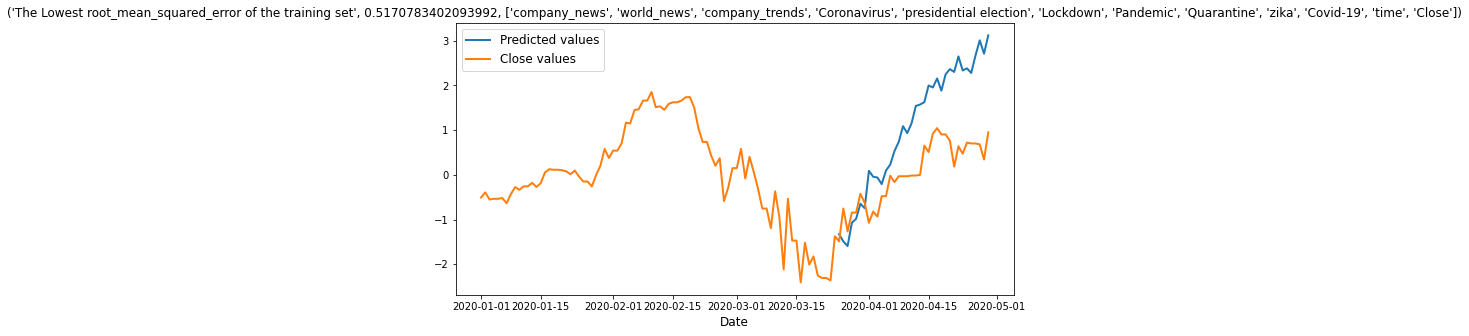

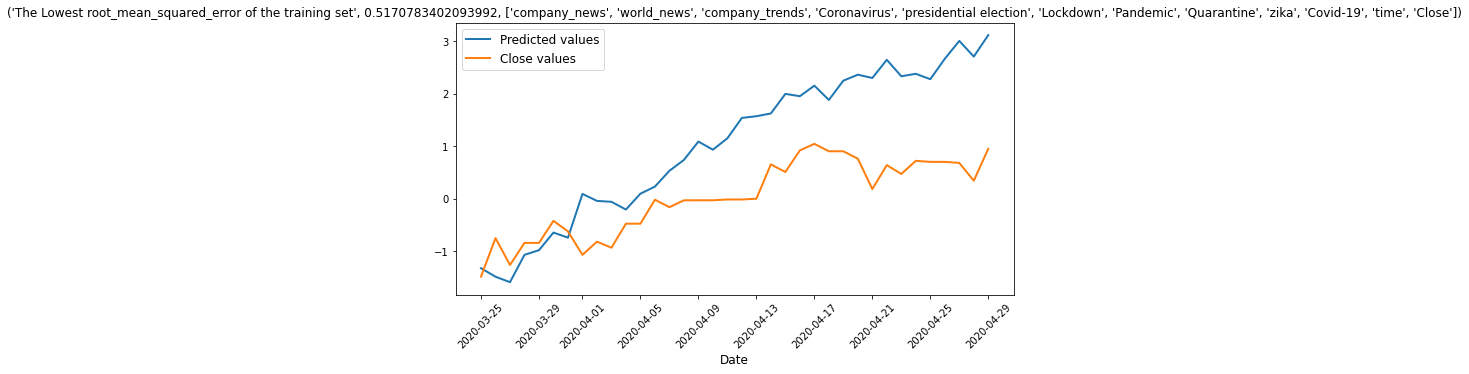

Root_mean_squared_error of the testing set:  1.3037983045416848
neg_mean_squared_error of the testing set:  -1.633464837337297
mean_absolute_percentage_error of the testing set:  7715.972417987922
R2 score of the testing set:  -2.3889701977775264


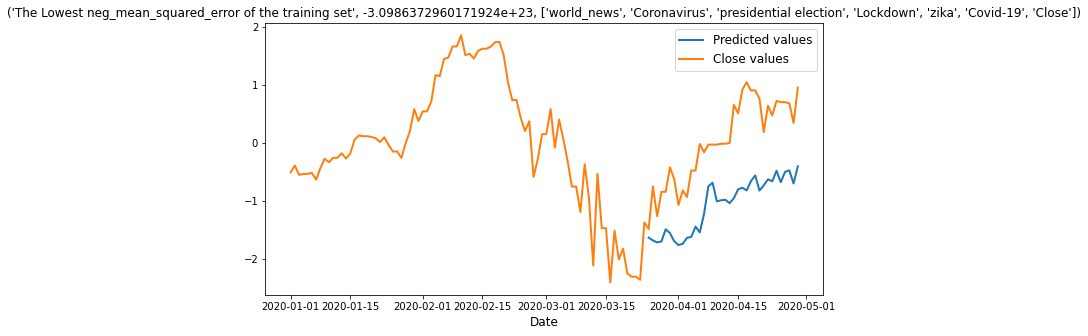

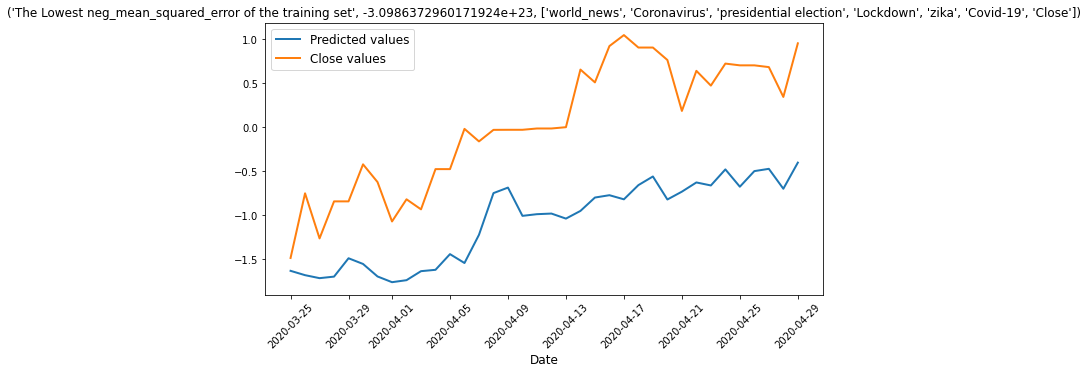

Root_mean_squared_error of the testing set:  1.1502750277461102
neg_mean_squared_error of the testing set:  -2.7329446920504554
mean_absolute_percentage_error of the testing set:  5396.019352125496
R2 score of the testing set:  -1.6378512920840738


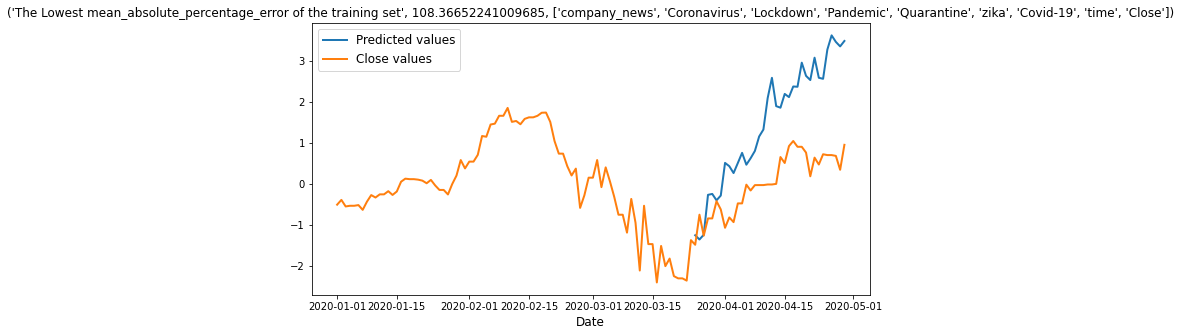

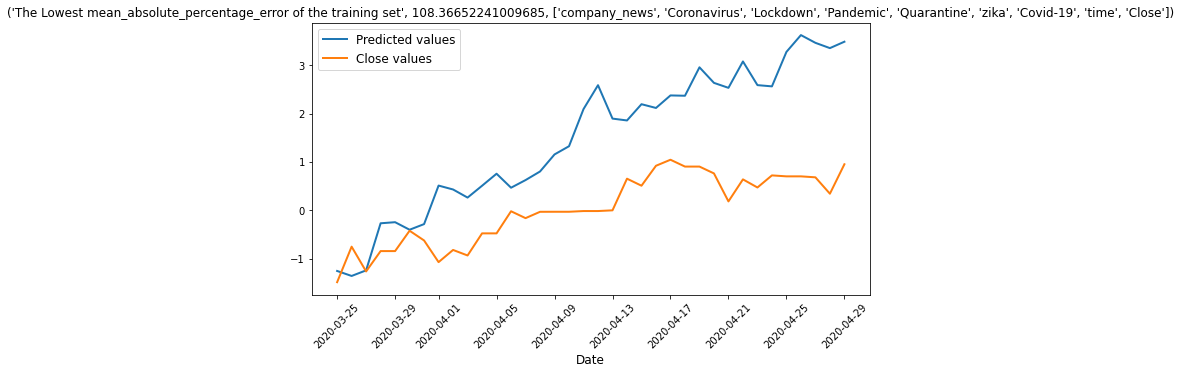

Root_mean_squared_error of the testing set:  1.6999800455437766
neg_mean_squared_error of the testing set:  -12.461679163552452
mean_absolute_percentage_error of the testing set:  9590.808649135923
R2 score of the testing set:  -4.761486824847812


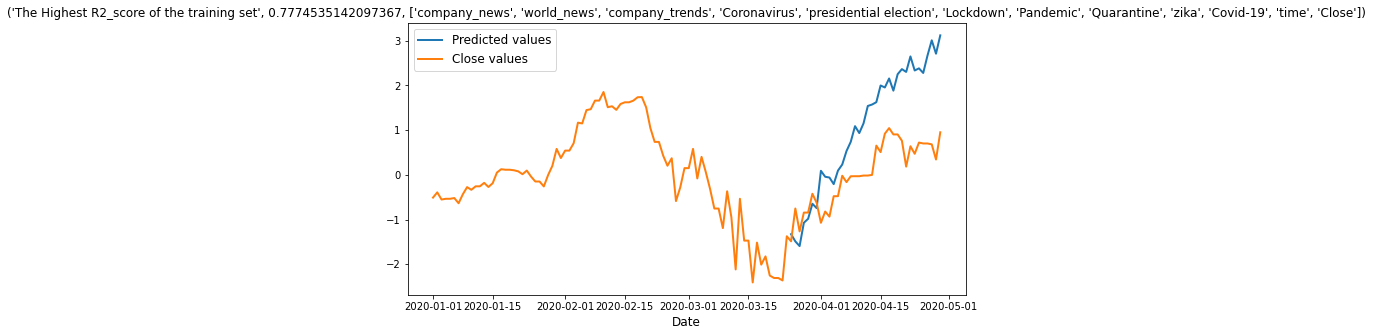

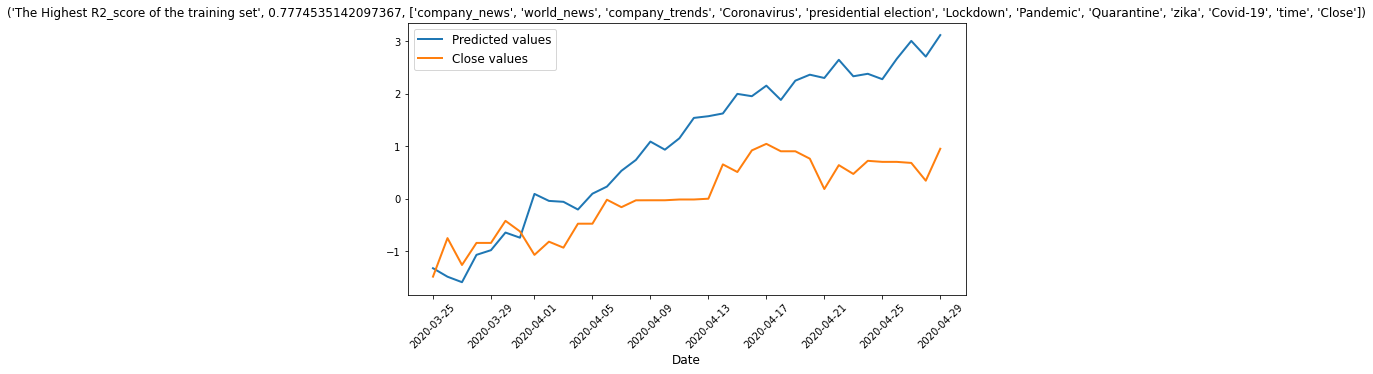

Root_mean_squared_error of the testing set:  1.3037983045416848
neg_mean_squared_error of the testing set:  -1.633464837337297
mean_absolute_percentage_error of the testing set:  7715.972417987922
R2 score of the testing set:  -2.3889701977775264


In [16]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

In [18]:
print("The best performance features:", "['zika','time','presidential election','company_trends','Close'] from the Zika timewindow based_on_Coefficients")
# print("Root_mean_squared_error:  0.5465783029765965")
# print('neg_mean_squared_error:  -0.8955461890497673')
# print('mean_absolute_percentage_error:  540.2510572525581')
# print('R2 score:  0.5484881540385802')

# Root_mean_squared_error:  0.6643307731079597
# neg_mean_squared_error:  -1.046283564199458
# mean_absolute_percentage_error:  1641.962176322857
# R2 score:  0.1201357616259332

The best performance features: ['zika','time','presidential election','company_trends','Close'] from the Zika timewindow based_on_Coefficients
Root_mean_squared_error:  0.5465783029765965
neg_mean_squared_error:  -0.8955461890497673
mean_absolute_percentage_error:  540.2510572525581
R2 score:  0.5484881540385802


In [17]:
features_from_other_timewindows_based_on_Coefficients = [[['zika','time','presidential election','company_trends','Close'],"Zika"],
                                                         [['time','presidential election','Pandemic','company_trends','Close'],'Election 2012'],
                                                         [['time','zika','Lockdown','company_trends','Close'], 'Election 2016']]


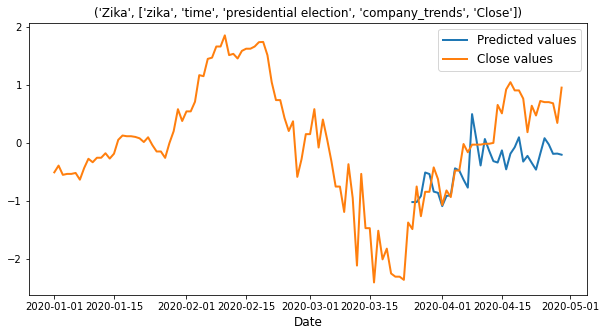

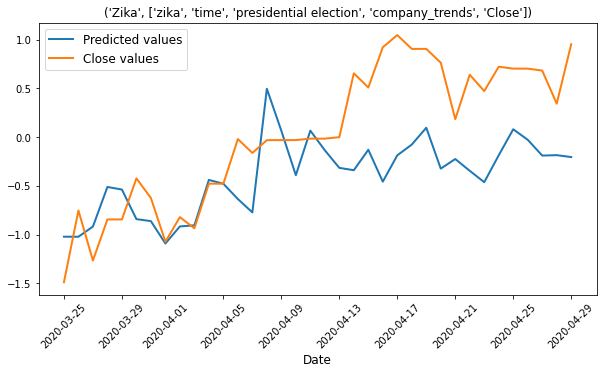

Root_mean_squared_error:  0.6643307731079597
neg_mean_squared_error:  -1.046283564199458
mean_absolute_percentage_error:  1641.962176322857
R2 score:  0.1201357616259332


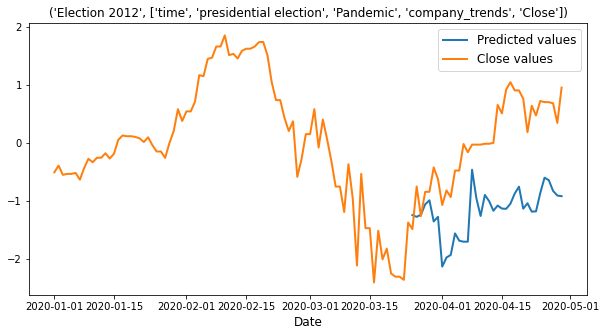

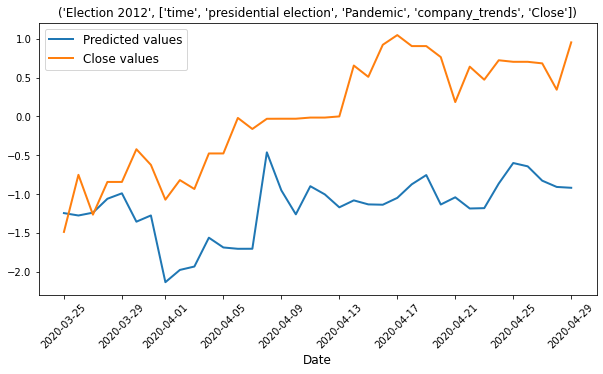

Root_mean_squared_error:  1.3282583451327497
neg_mean_squared_error:  -2.8630768877860175
mean_absolute_percentage_error:  6015.742238656108
R2 score:  -2.517321219915858


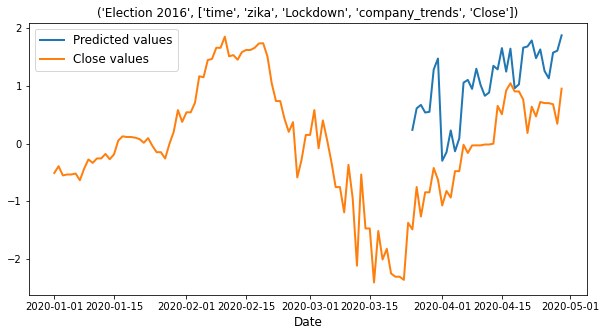

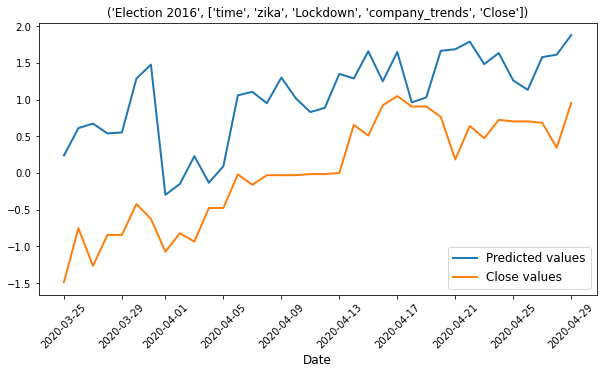

Root_mean_squared_error:  1.114809812160146
neg_mean_squared_error:  -0.24032674695390321
mean_absolute_percentage_error:  6718.0633662030405
R2 score:  -1.4776986884851815


In [18]:
for k,i in enumerate(features_from_other_timewindows_based_on_Coefficients):

    df_1 = std_df[i[0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.xticks(rotation=45)
    plt.show()
    
        # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score: ", R2_score)

# Zika

In [21]:
# removing covid_19, coronavirus features which have only 0s.
df = Zika[['company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        'time', 'Close']]

In [22]:
df.index = pd.to_datetime(df.index)


In [23]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [24]:
cutIdx = int(len(std_df)*0.7)

In [25]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Zika timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Zika timewindow: 
                       Coefficient
zika                      0.942528
time                      0.236923
Bias_Constant            -0.112960
presidential election    -0.098300
company_trends           -0.083854
Pandemic                  0.063649
Quarantine               -0.048335
Lockdown                 -0.017438
company_news             -0.006323
world_news                0.002292


In [26]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [27]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [28]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [29]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [30]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

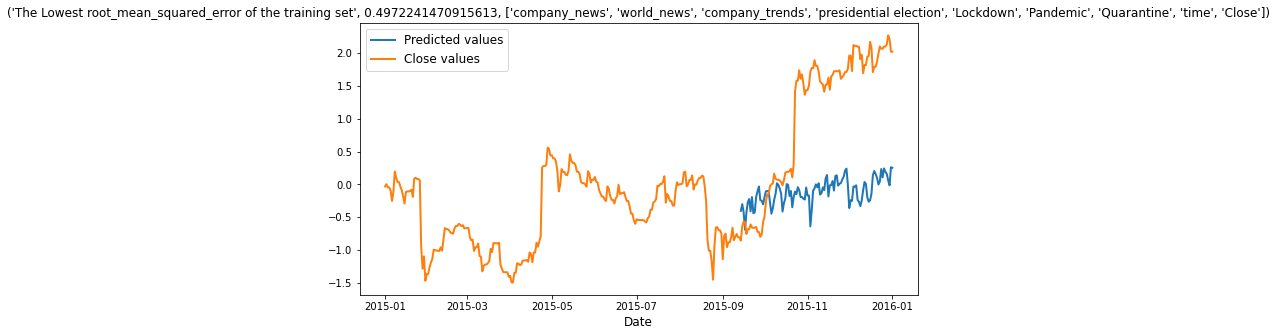

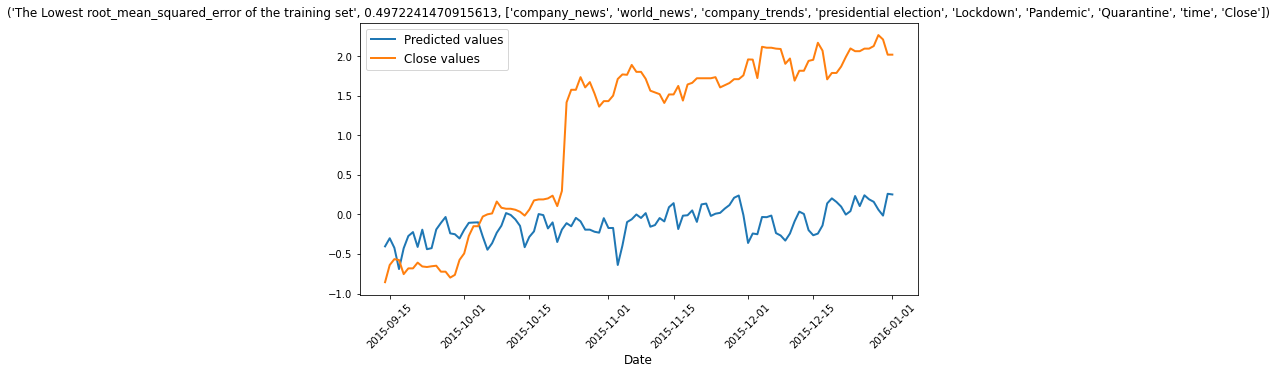

Root_mean_squared_error of the testing set:  1.5053122983026337
neg_mean_squared_error of the testing set:  -0.29324591109095044
mean_absolute_percentage_error of the testing set:  399.68330743068
R2 score of the testing set:  -1.131740165055969


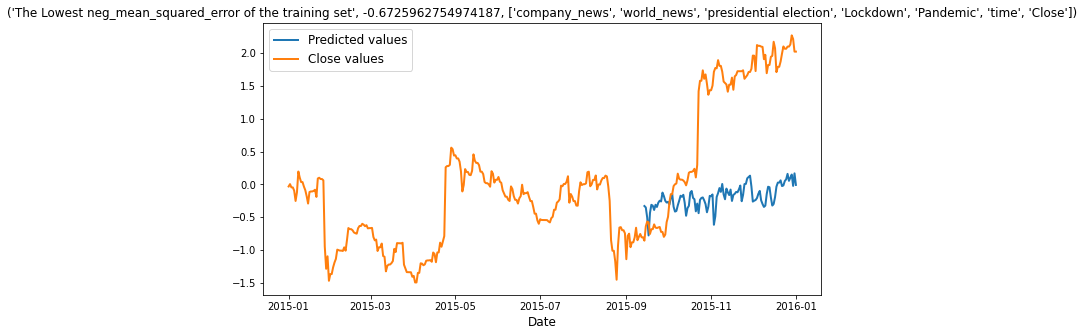

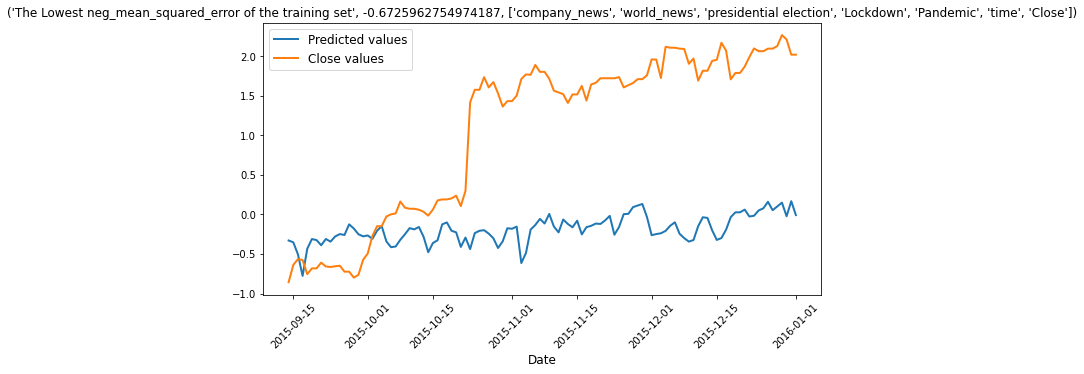

Root_mean_squared_error of the testing set:  1.571307964249775
neg_mean_squared_error of the testing set:  -0.33946668918155565
mean_absolute_percentage_error of the testing set:  409.85222087818204
R2 score of the testing set:  -1.3227564349123089


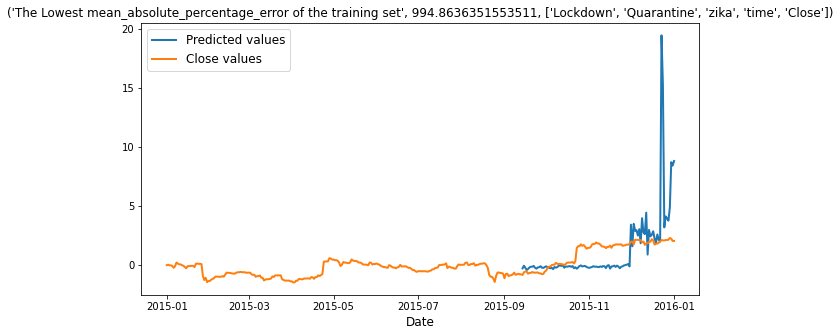

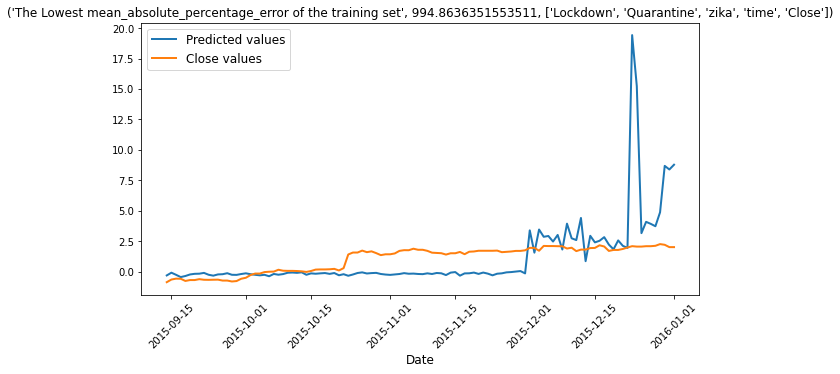

Root_mean_squared_error of the testing set:  2.6494649563626176
neg_mean_squared_error of the testing set:  -2.441468964454232e+22
mean_absolute_percentage_error of the testing set:  343.58318194064776
R2 score of the testing set:  -5.603853155223115


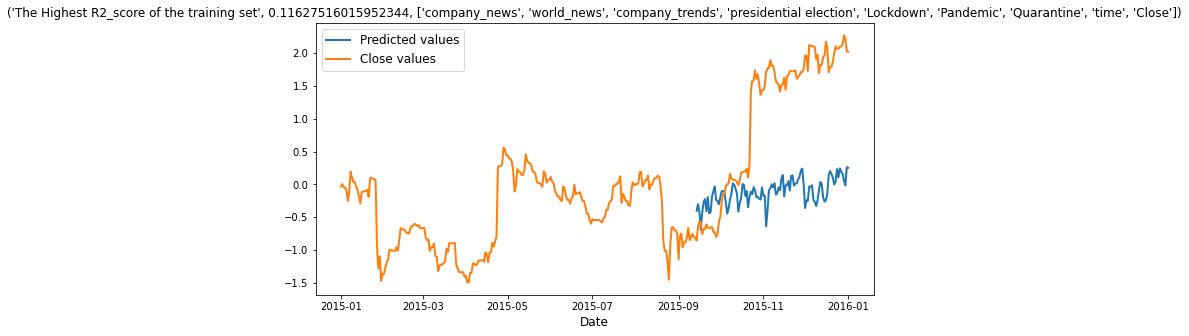

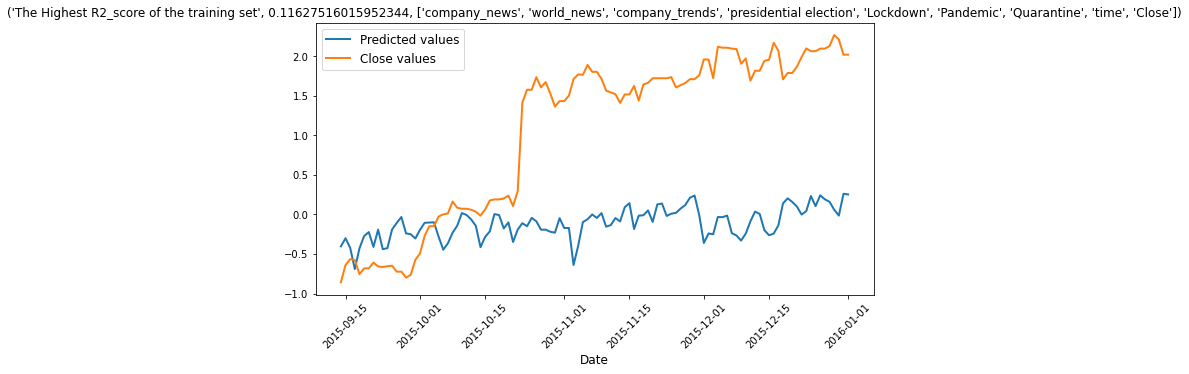

Root_mean_squared_error of the testing set:  1.5053122983026337
neg_mean_squared_error of the testing set:  -0.29324591109095044
mean_absolute_percentage_error of the testing set:  399.68330743068
R2 score of the testing set:  -1.131740165055969


In [31]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2012

In [32]:
# removing covid_19, coronavirus, zika features which have only 0s.
df = election_2012[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
        'time', 'Close']]

In [33]:
df.index = pd.to_datetime(df.index)


In [34]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [35]:
cutIdx = int(len(std_df)*0.7)

In [36]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Election 2012 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Election 2012 timewindow: 
                       Coefficient
time                     -0.856352
Bias_Constant            -0.671217
Pandemic                 -0.124226
presidential election     0.110011
company_trends            0.107900
Lockdown                  0.078888
company_news             -0.056692
Quarantine                0.013979
world_news               -0.002962


In [37]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [38]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [39]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [40]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [41]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

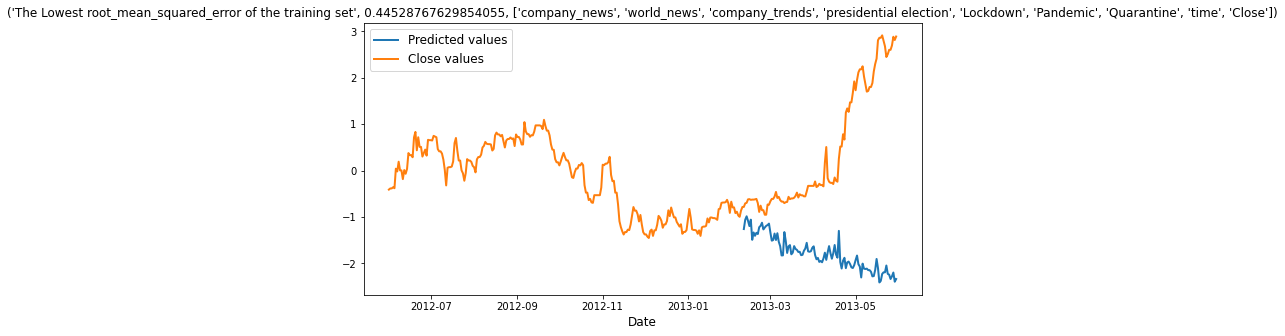

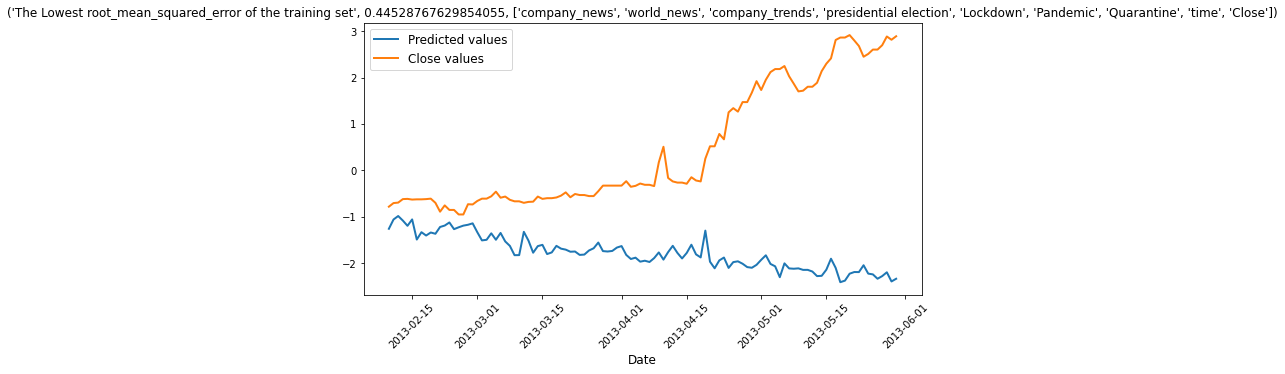

Root_mean_squared_error of the testing set:  2.7448483138406465
neg_mean_squared_error of the testing set:  -0.489110065030514
mean_absolute_percentage_error of the testing set:  264.7540698805771
R2 score of the testing set:  -3.4057861883449725


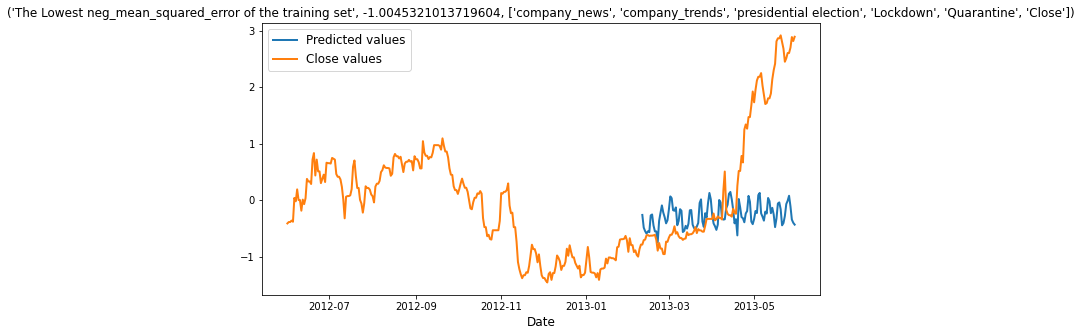

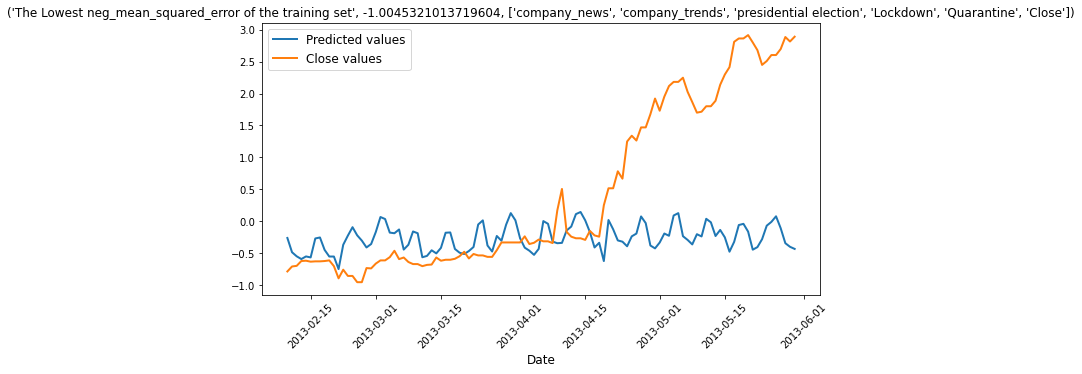

Root_mean_squared_error of the testing set:  1.4586928411745512
neg_mean_squared_error of the testing set:  -1.467213253822165
mean_absolute_percentage_error of the testing set:  80.93417930709987
R2 score of the testing set:  -0.24426940197486102


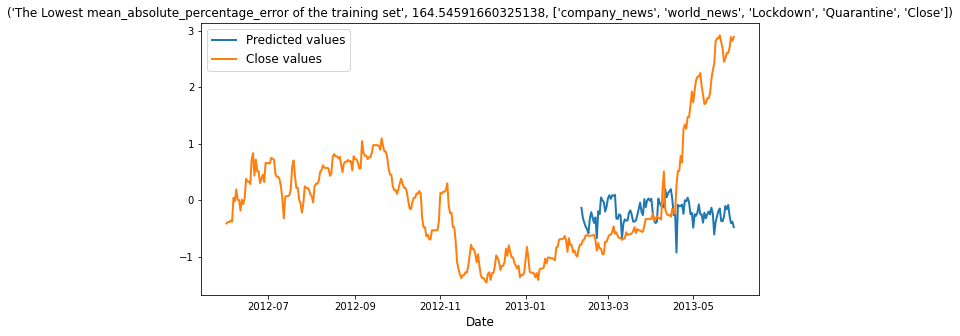

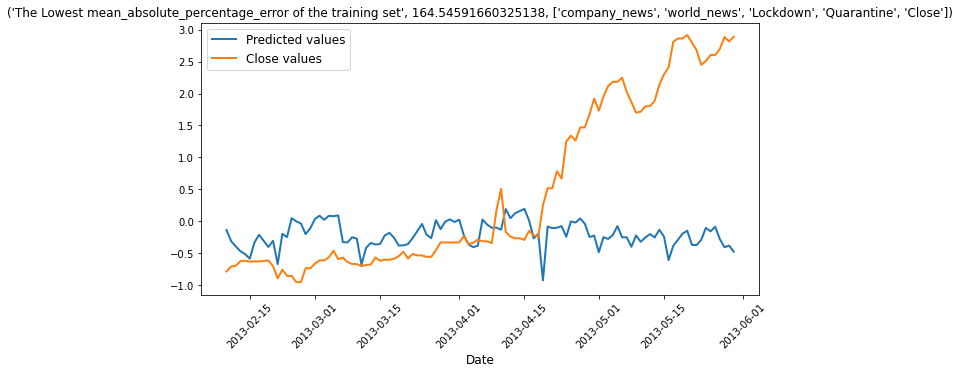

Root_mean_squared_error of the testing set:  1.4967151659700753
neg_mean_squared_error of the testing set:  -1.9102957987127784
mean_absolute_percentage_error of the testing set:  90.66928828040247
R2 score of the testing set:  -0.3099811214202062


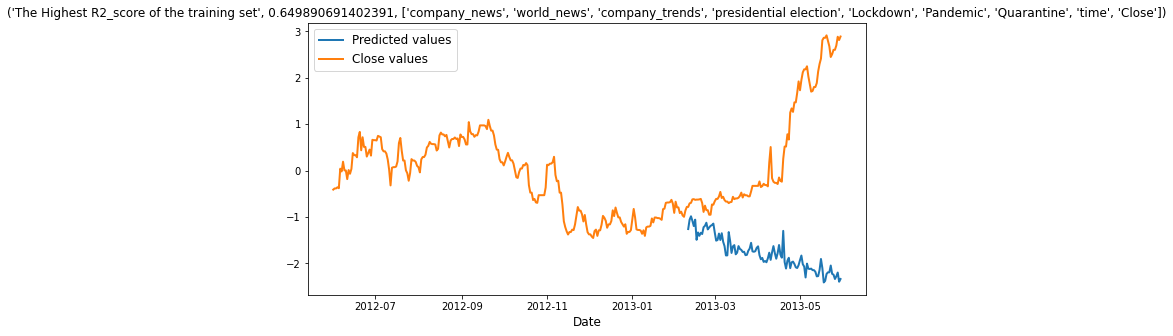

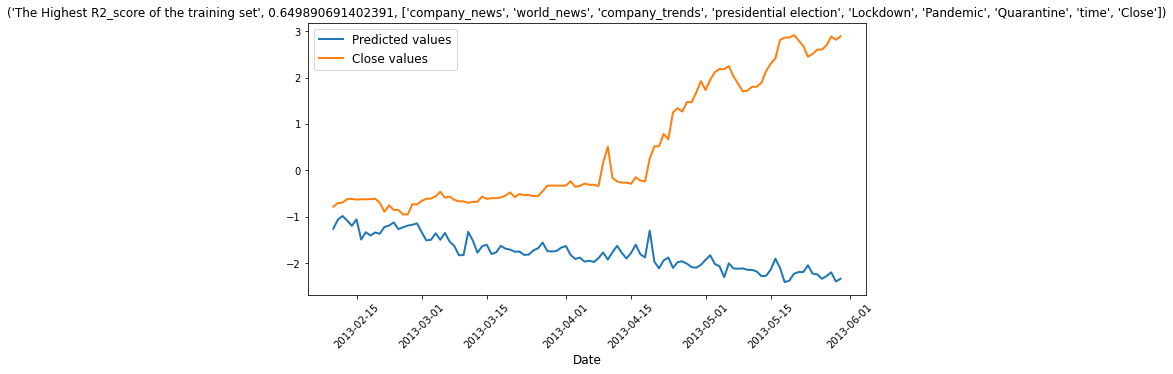

Root_mean_squared_error of the testing set:  2.7448483138406465
neg_mean_squared_error of the testing set:  -0.489110065030514
mean_absolute_percentage_error of the testing set:  264.7540698805771
R2 score of the testing set:  -3.4057861883449725


In [42]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2016

In [43]:
# removing covid_19, coronavirus features which have only 0s.
df = election_2016[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'time', 'Close']]

In [44]:
df.index = pd.to_datetime(df.index)


In [45]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [46]:
cutIdx = int(len(std_df)*0.7)

In [47]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Election 2016 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Election 2016 timewindow: 
                       Coefficient
time                      1.246742
zika                      0.153194
Bias_Constant             0.124010
Lockdown                 -0.057966
company_trends            0.034651
company_news             -0.031721
Pandemic                 -0.030844
world_news               -0.025802
Quarantine               -0.023662
presidential election     0.013662


In [48]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [49]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [50]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [51]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [52]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

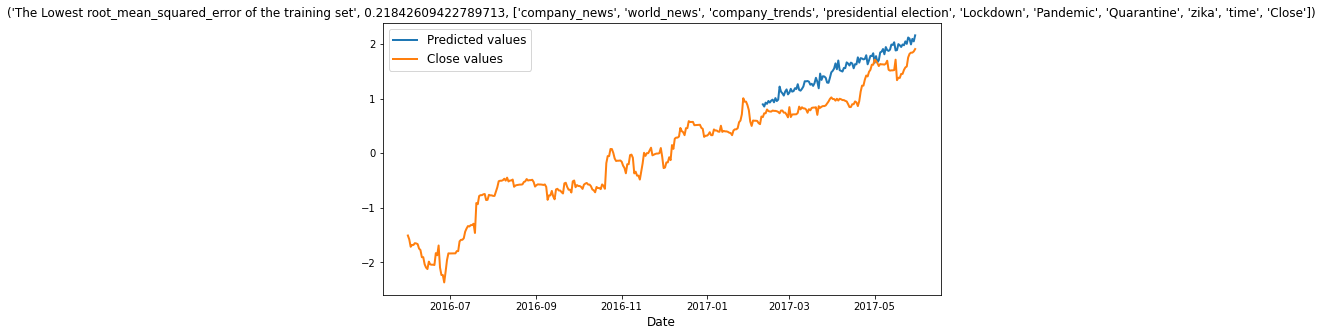

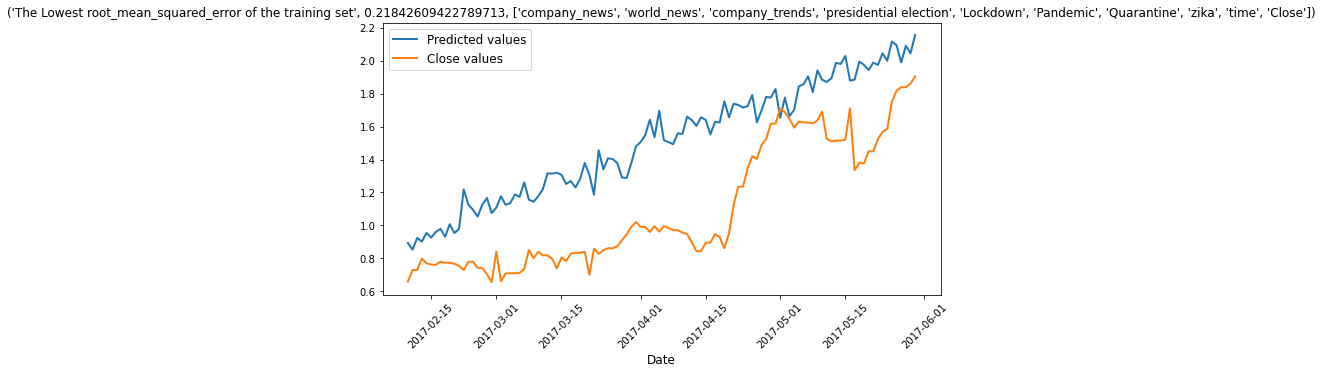

Root_mean_squared_error of the testing set:  0.4510737819850133
neg_mean_squared_error of the testing set:  -0.05052880900121757
mean_absolute_percentage_error of the testing set:  42.89980789987529
R2 score of the testing set:  -0.45410523539274816


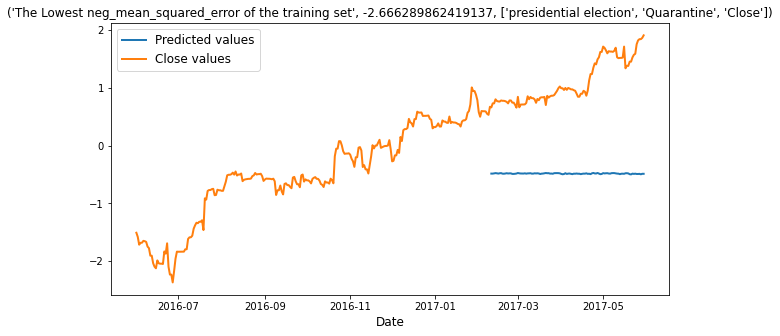

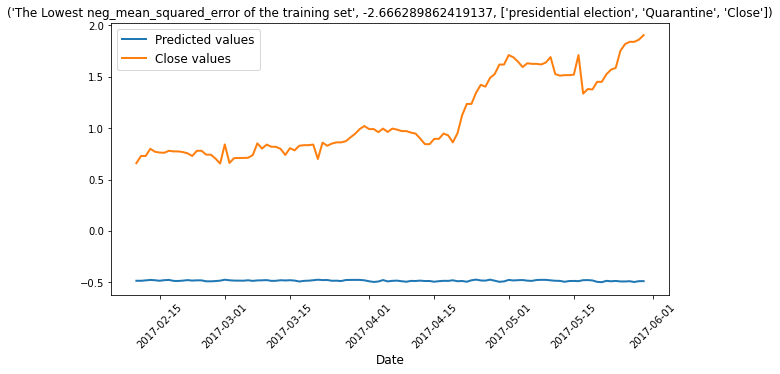

Root_mean_squared_error of the testing set:  1.6265786364397894
neg_mean_squared_error of the testing set:  -0.16151030759091528
mean_absolute_percentage_error of the testing set:  148.87789711198354
R2 score of the testing set:  -17.908226490762804


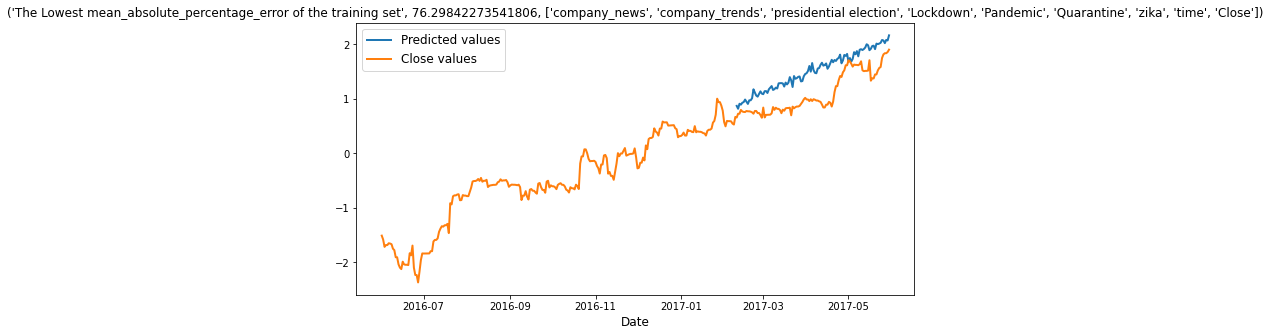

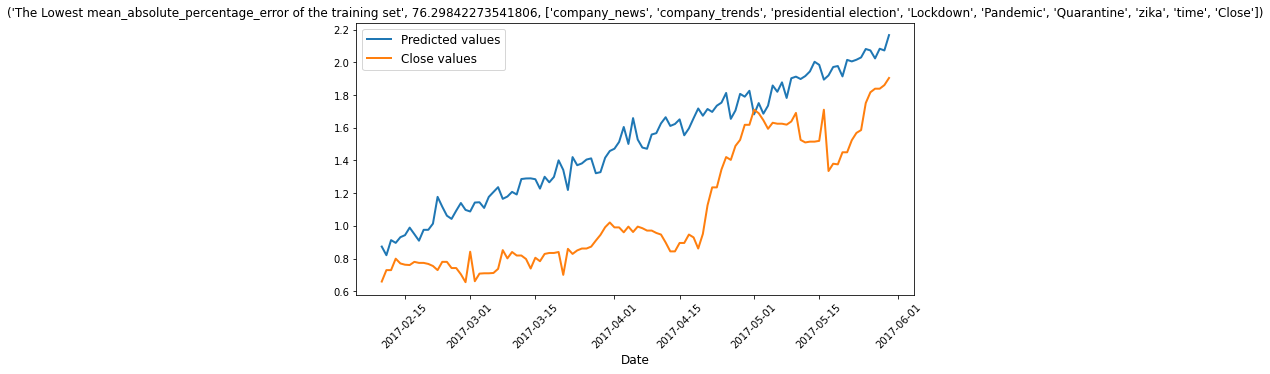

Root_mean_squared_error of the testing set:  0.4476977940554096
neg_mean_squared_error of the testing set:  -0.04516711866663299
mean_absolute_percentage_error of the testing set:  42.55893613607868
R2 score of the testing set:  -0.43242066201015406


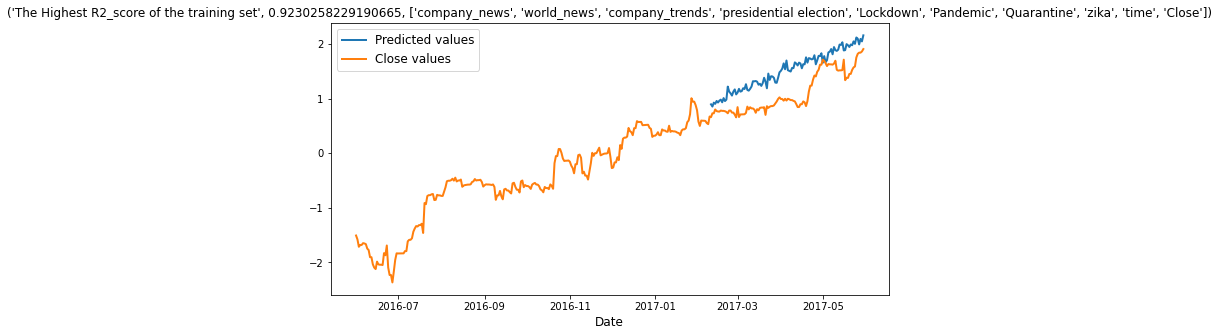

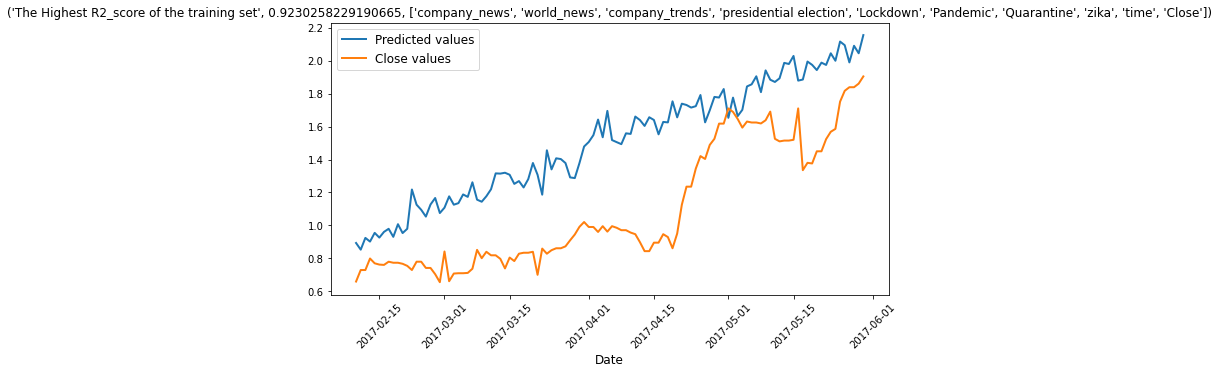

Root_mean_squared_error of the testing set:  0.4510737819850133
neg_mean_squared_error of the testing set:  -0.05052880900121757
mean_absolute_percentage_error of the testing set:  42.89980789987529
R2 score of the testing set:  -0.45410523539274816


In [53]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# 10 years

In [67]:
# removing covid_19, coronavirus features which have only 0s.
df = Company


In [68]:
df.index = pd.to_datetime(df.index)


In [69]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [70]:
cutIdx = int(len(std_df)*0.7)

In [71]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 'Coronavirus',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
       'Covid-19', 'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the 10 years timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the 10 years timewindow: 
                       Coefficient
Coronavirus               1.729468
Covid-19                  0.711548
time                      0.531498
Pandemic                  0.267054
Quarantine               -0.240926
Bias_Constant            -0.051998
zika                     -0.027703
Lockdown                  0.009505
company_trends           -0.009348
company_news             -0.007942
world_news                0.004788
presidential election    -0.002987


In [72]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [73]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [74]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [75]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [76]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

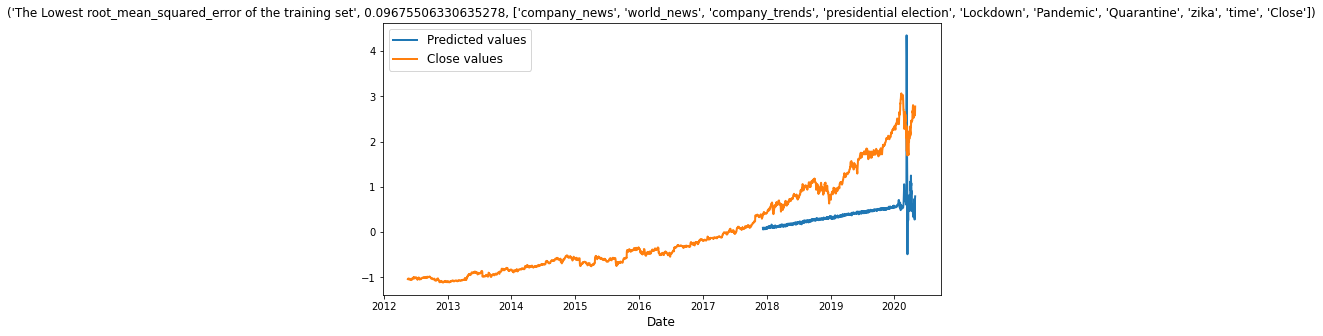

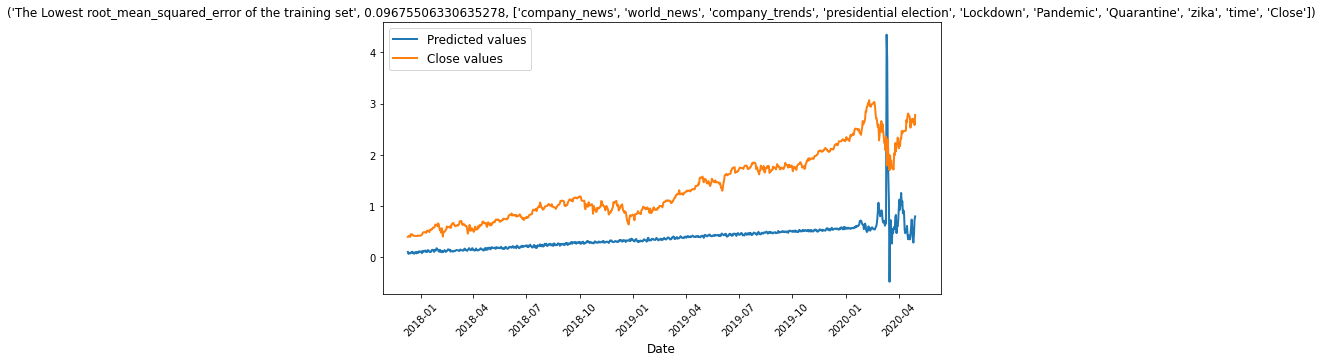

Root_mean_squared_error of the testing set:  1.1070507383730694
neg_mean_squared_error of the testing set:  -10.975926422566149
mean_absolute_percentage_error of the testing set:  73.09670026078967
R2 score of the testing set:  -1.8472961802172785


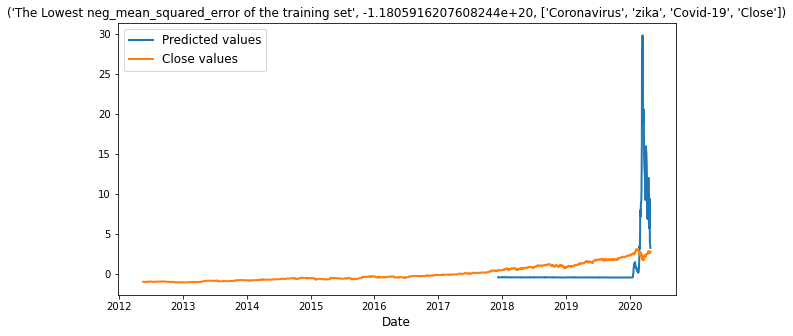

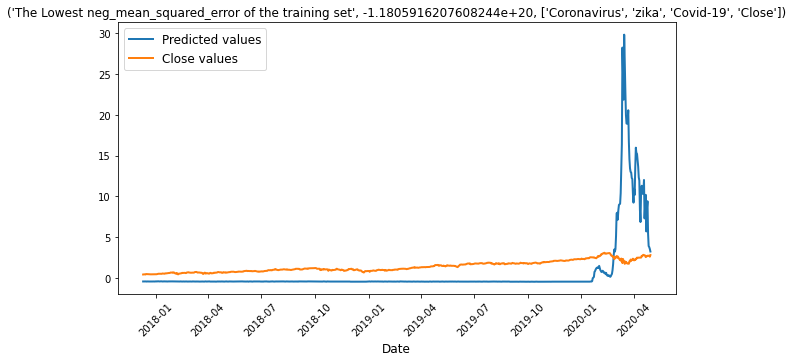

Root_mean_squared_error of the testing set:  3.5844704702727217
neg_mean_squared_error of the testing set:  -2.85686004849494e+16
mean_absolute_percentage_error of the testing set:  168.23735787878334
R2 score of the testing set:  -28.850224892265363


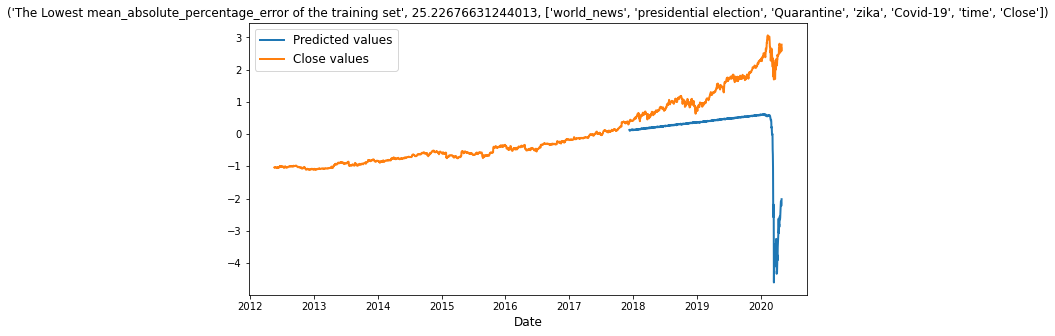

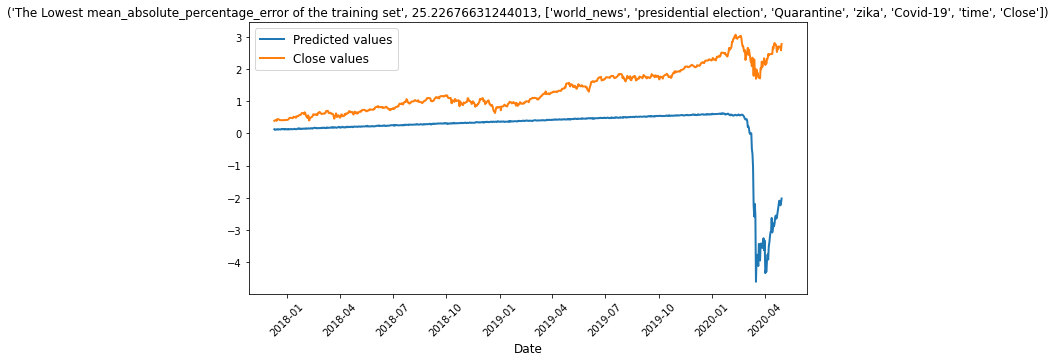

Root_mean_squared_error of the testing set:  1.6563485683448869
neg_mean_squared_error of the testing set:  -6.9026327793229
mean_absolute_percentage_error of the testing set:  79.56154999735135
R2 score of the testing set:  -5.373838673383197


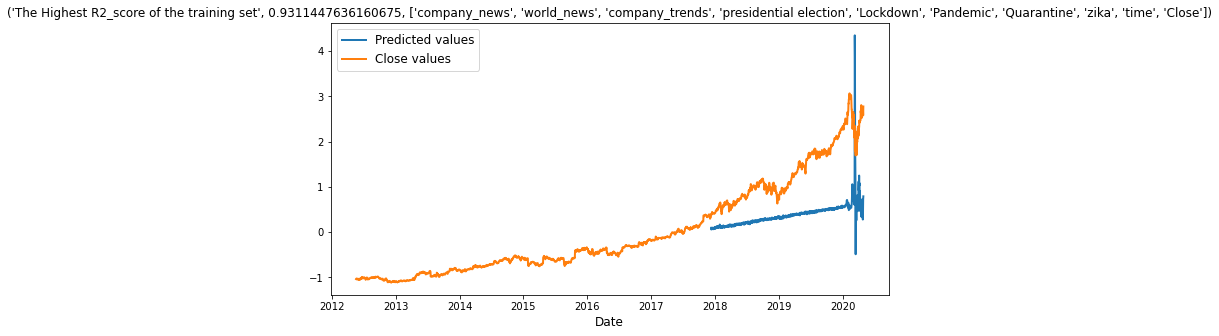

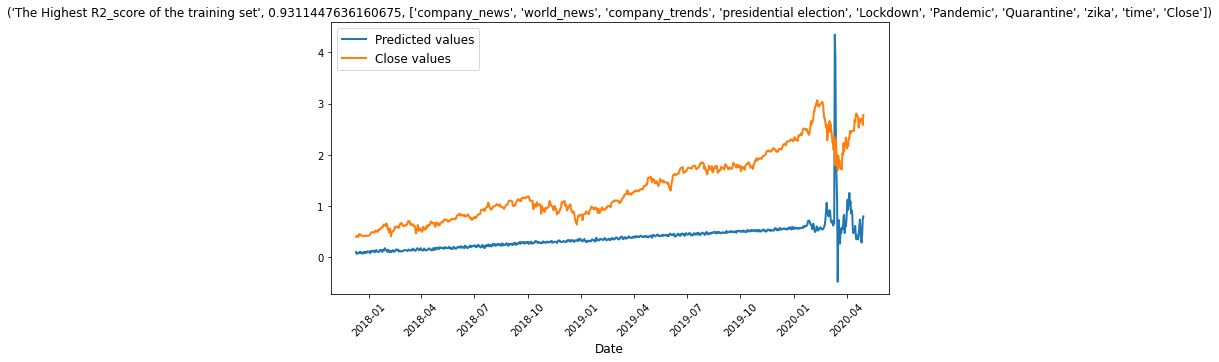

Root_mean_squared_error of the testing set:  1.1070507383730694
neg_mean_squared_error of the testing set:  -10.975926422566149
mean_absolute_percentage_error of the testing set:  73.09670026078967
R2 score of the testing set:  -1.8472961802172785


In [77]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)